# Giới thiệu


Mã hoá dữ liệu danh mục (categorical encoding) là quá trình chuyển đổi các biến danh mục (categorical variables) thành các đặc trưng dạng số. Đây là một bước quan trọng trong kỹ thuật xây dựng đặc trưng (feature engineering) của hầu hết các dự án khoa học dữ liệu, nhằm đảm bảo rằng các thuật toán máy học có thể xử lý và diễn giải dữ liệu danh mục một cách phù hợp.


## Tầm quan trọng của mã hoá dữ liệu danh mục

Hầu hết các thuật toán máy học, như hồi quy tuyến tính (linear regression), máy vector hỗ trợ (SVM) và hồi quy logistic (logistic regression) đều yêu cầu dữ liệu đầu vào ở dạng số, vì chúng sử dụng các phép tính số học để học mối quan hệ giữa các đặc trưng dự báo (predictor features) và biến mục tiêu (target variable). Do đó, các thuật toán này không có khả năng diễn giải dữ liệu danh mục một cách tự nhiên. Chính vì vậy, mã hoá dữ liệu danh mục là một bước quan trọng, giúp đảm bảo dữ liệu đầu vào phù hợp với yêu cầu của các mô hình máy học.

Một số triển khai của các thuật toán dựa trên cây quyết định có thể xử lý trực tiếp dữ liệu danh mục. Tuy nhiên, mã hoá các đặc trưng danh mục vẫn nên được áp dụng nhằm giảm bớt độ phong phú của danh mục (cardinality) hoặc xử lý những giá trị chưa từng xuất hiện trong dữ liệu huấn luyện (unseen categories).

## Biến danh mục (categorical variables)
Các biến danh mục là những biến mà giá trị của chúng là những giá trị rời rạc được chọn từ một nhóm các hạng mục hoặc nhãn. Giá trị của chúng có thể là dạng chuỗi hoặc dạng số.

Ví dụ:
- “màu sắc” là một đặc trưng danh mục, có thể nhận các giá trị như "đỏ", "vàng" hoặc "cam"

## Các kiểu dữ liệu danh mục
Các đặc trưng danh mục có thể thuộc loại danh nghĩa (nominal) hoặc thứ bậc (ordinal).

*   Danh nghĩa (Nominal): Là những đặc trưng danh mục mà các hạng mục không có thứ tự hoặc cấp bậc rõ ràng. Ví dụ, “màu sắc” là một đặc trưng danh nghĩa, bởi mỗi màu đại diện cho một giá trị độc lập, không có thứ bậc cụ thể.
*   Thứ bậc (Ordinal): Là những đặc trưng danh mục mà các hạng mục được sắp xếp theo một trật tự hay cấp bậc vốn có. Ví dụ, “kích thước” là một đặc trưng thứ bậc, vì các kích thước có thể được sắp xếp từ nhỏ đến lớn.
Việc nhận biết đặc trưng danh mục là danh nghĩa hay thứ bậc giúp chúng ta lựa chọn phương pháp mã hoá phù hợp để chuyển đổi các giá trị của chúng sang dạng số.

# Các kỹ thuật mã hoá biến danh mục

Có nhiều phương pháp mã hoá dữ liệu danh mục mà chúng ta có thể sử dụng để chuyển đổi các đặc trưng danh mục sang dạng số. One-hot encoding và ordinal encoding là những kỹ thuật phổ biến nhất, nhưng vẫn có các phương pháp mã hoá khác có khả năng giải quyết vấn đề độ phong phú danh mục (high cardinality) và các danh mục hiếm (rare categories).

### Giới thiệu dataset

In [ ]:
import numpy as np
import pandas as pd
house_data_df = pd.read_csv('Bengaluru_House_Data.csv')
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [ ]:
house_data_df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
house_data_df = house_data_df.dropna(subset=['size','bath', 'balcony']).drop(columns=['availability','society', 'location'])

In [ ]:
### chuẩn hoá dữ liệu cột 'total_sqft'

import re

def convert_sqft_to_num(sqft):
    try:
        # Case 1: Handle ranges like '1200-1500'
        if '-' in sqft:
            sqft_range = list(map(float, sqft.split('-')))
            return np.mean(sqft_range)
        # Case 2: Extract numbers from alphanumeric values (e.g., '34.46Sq. Meter')
        elif re.match(r'\d+(\.\d+)?', sqft):
            return float(re.search(r'\d+(\.\d+)?', sqft).group())
        else:
            return None  # Return None if conversion fails
    except:
        return None

# Apply the function to 'total_sqft' column
house_data_df['total_sqft'] = house_data_df['total_sqft'].apply(convert_sqft_to_num)

## Bài toán áp dụng
Báo cáo này tìm hiểu các kỹ thuật mã hoá danh mục và áp dụng xây dựng mô hình hồi quy dự đoán giá của một ngôi nhà dựa trên một số đặc trưng, sử dụng song song 2 thuật toán Linear regression và Decision Tree regressor để so sánh hiệu suất của mỗi kỹ thuật mã hoá.
Báo cáo sử dụng thư viện Scikit Learn kết hợp với Pandas và category_encoders để trình bày các kỹ thuật mã hoá biến danh mục.

In [ ]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# prepare dataset
X = house_data_df.drop(columns=['price'])
y = house_data_df['price']

# scores for comparison
scores= []

## One-hot encoding
One-hot encoding là kỹ thuật thay thế các biến danh mục bằng một tập các biến nhị phân đại diện cho một trong các giá trị của biến danh mục.
### Các bước thực hiện
- Tạo thêm k biến nhị phân tương ứng với k giá trị danh mục
- Biến nhị phân tương ứng với giá trị danh mục của dòng dữ liệu có giá trị 1, các biến còn lại có giá trị 0.

Ví dụ, với biến danh mục area_type có 4 giá trị danh mục khác nhau: "Carpet  Area", "Built-up  Area", "Super built-up  Area" và "Plot  Area", One-hot encoding sẽ thay thế biến area_type bằng 4 biến nhị phân riêng biệt.

In [ ]:
house_data_df['area_type'].value_counts()

area_type
Super built-up  Area    8482
Built-up  Area          2310
Plot  Area              1837
Carpet  Area              82
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

area_type_column = house_data_df[['area_type']]
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
area_type_column_encoded = encoder.fit_transform(area_type_column)
area_type_column_encoded

,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
13314,0.0,0.0,0.0,1.0
13315,1.0,0.0,0.0,0.0
13317,1.0,0.0,0.0,0.0
13318,0.0,0.0,0.0,1.0


### Dummies Encoding
Dummies encoding tương tự như One-Hot encoding nhưng tạo ra ít hơn một biến nhị phân. Với một biến danh mục có k giá trị, Dummies encoding tạo ra k-1 biến nhị phân. Biến giá trị còn lại được suy ra từ k-1 biến giá trị kia.
Ví dụ:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

area_type_column = house_data_df[['area_type']]
encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")
area_type_column_encoded = encoder.fit_transform(area_type_column)
area_type_column_encoded

,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
13314,0.0,0.0,1.0
13315,0.0,0.0,0.0
13317,0.0,0.0,0.0
13318,0.0,0.0,1.0


#### Trường hợp sử dụng:
- phù hợp với các mô hình tuyến tính vì mỗi danh mục được sử dụng độc lập với nhau, và các mô hình tuyến tính xử lý các biến nhị phân rất hiệu quả
- Biến danh mục có ít giá trị (độ phong phú danh mục thấp).
- Không tồn tại mối quan hệ thứ bậc có ý nghĩa giữa các danh mục.
#### Hạn chế
- One-hot encoding làm tăng số lượng chiều dữ liệu bởi vì mỗi giá trị danh mục sẽ được thêm vào như là một biến mới. Do đó, One-hot encoding không phù hợp với các đặc trưng có số lượng lớn (high cardinality) vì nó làm tăng nhanh chóng số chiều dữ liệu, dễ gây tràn bộ nhớ, làm chậm và giảm hiệu quả quá trình huấn luyện. Không hiệu quả khi sử dụng với các mô hình dựa trên cây.

### Áp dụng

In [ ]:
np.random.seed(42)

categories = ['area_type', 'size']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = OneHotEncoder(sparse_output=False, categories='auto', handle_unknown="ignore").set_output(transform="pandas")

# let encoder identifies the categories from train dataset
encoder.fit(X_train[categories])

# encoding
X_train_enc = encoder.transform(X_train[categories])
X_test_enc = encoder.transform(X_test[categories])

X_train = pd.concat([X_train, X_train_enc], axis=1).drop(columns=categories)
X_test = pd.concat([X_test, X_test_enc], axis=1).drop(columns=categories)


# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['One-Hot', linear_score,decision_tree_score])

Linear regression score: 0.35452993605382055
DecisionTreeRegressor score: 0.5486425302376741


## Mã hoá nhãn (Label encoding)
Label encoding là một kỹ thuật được sử dụng để chuyển đổi các biến danh mục thành các mã số nguyên, trong đó mỗi giá trị danh mục được gán một giá trị số nguyên duy nhất (ví dụ: 0, 1, 2, …).
### Các bước thực hiện
- Xác định các giá trị riêng biệt trong biến danh mục.
- Gán giá trị số nguyên cho mỗi giá trị trong danh mục.
- Thay thế các chuỗi gốc trong đặc trưng bằng các mã số nguyên tương ứng.

Ví dụ:

In [ ]:
from sklearn.preprocessing import LabelEncoder

area_type_column = house_data_df[['area_type']]
encoder = LabelEncoder()
area_type_column_encoded = encoder.fit_transform(area_type_column.values.flatten())
encoded_df = pd.DataFrame()
encoded_df['area_type_encoded'] = area_type_column_encoded
result = pd.concat([house_data_df, encoded_df], axis=1)
result.head()

,area_type,size,total_sqft,bath,balcony,price,area_type_encoded
0,Super built-up Area,2 BHK,1056.0,2.0,1.0,39.07,3.0
1,Plot Area,4 Bedroom,2600.0,5.0,3.0,120.00,2.0
2,Built-up Area,3 BHK,1440.0,2.0,3.0,62.00,0.0
3,Super built-up Area,3 BHK,1521.0,3.0,1.0,95.00,3.0
4,Super built-up Area,2 BHK,1200.0,2.0,1.0,51.00,3.0


#### Trường hợp sử dụng:
- Label encoding thường được sử dụng để mã hoá biến đích đối với bài toán phân loại

## Mã hoá thứ bậc (Ordinal Encoding)

Mã hoá thứ bậc (Ordinal Encoding) là phương pháp chuyển đổi các biến danh mục thành các giá trị số nguyên, trong đó thứ tự của các giá trị số này phản ánh thứ tự tự nhiên (thứ bậc) của các hạng mục.

### Các bước thực hiện
- Xác định thứ tự của các giá trị danh mục.
- Gán cho mỗi hạng mục một giá trị số nguyên thể hiện vị trí của nó trong thứ tự.

Ví dụ, trong dataset ta xem xét tương quan giữa biến 'area_type' và giá trị trung bình của biến đích để tìm thứ bậc của các giá trị trong danh mục. Mã hoá thứ bậc sẽ cho ra kết quả dưới đây:

In [ ]:
ordered_area_types = house_data_df.groupby(['area_type'])['price'].mean().sort_values().index
print(ordered_area_types)

Index(['Carpet  Area', 'Super built-up  Area', 'Built-up  Area', 'Plot  Area'], dtype='object', name='area_type')


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

area_type_column = house_data_df[['area_type']]
category_order = [list(ordered_area_types)]
encoder = OrdinalEncoder(categories=category_order).set_output(transform="pandas")
area_type_column_encoded = encoder.fit_transform(area_type_column)
area_type_column_encoded.rename(columns={'area_type': 'area_type_encoded'}, inplace=True)
area_type_column_encoded

,area_type_encoded
0,1.0
1,3.0
2,2.0
3,1.0
4,1.0
...,...
13314,1.0
13315,2.0
13317,2.0
13318,1.0


Xem xét kết quả mã hoá trong bộ dữ liệu:

In [ ]:
area_type_column_encoded_df = pd.DataFrame(area_type_column_encoded)
ordinal_encoded_df = pd.concat([house_data_df, area_type_column_encoded_df], axis=1)
ordinal_encoded_df.head()

,area_type,size,total_sqft,bath,balcony,price,area_type_encoded
0,Super built-up Area,2 BHK,1056.0,2.0,1.0,39.07,1.0
1,Plot Area,4 Bedroom,2600.0,5.0,3.0,120.00,3.0
2,Built-up Area,3 BHK,1440.0,2.0,3.0,62.00,2.0
3,Super built-up Area,3 BHK,1521.0,3.0,1.0,95.00,1.0
4,Super built-up Area,2 BHK,1200.0,2.0,1.0,51.00,1.0


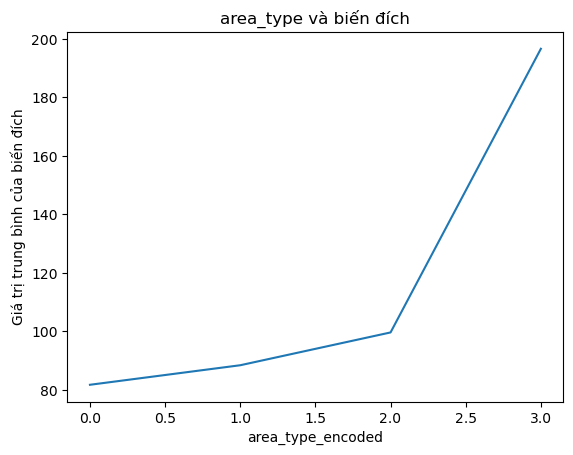

In [ ]:
import matplotlib.pyplot as plt

ordinal_encoded_df.groupby(['area_type_encoded'])['price'].mean().plot()
plt.title('area_type và biến đích')
plt.ylabel('Giá trị trung bình của biến đích')
plt.show()

### Trường hợp sử dụng
Ordinal encoding phù hợp với các mô hình dựa trên cây, bởi vì những mô hình này có khả năng diễn giải các quan hệ phi tuyến giữa biến được mã hóa và biến đích.

### Hạn chế
Ordinal encoding không có khả năng xử lý các danh mục chưa xuất hiện. Nếu một giá trị danh mục xuất hiện ở các bước sau của quá trình phát triển mô hình, trình mã hóa không biết được nên gán giá trị số nào cho giá trị danh mục đó, bởi vì các giá trị số được sinh ra dựa trên bộ dữ liệu huấn luyện. Điều này dẫn đến lỗi xảy ra và làm gián đoạn quy trình xây dựng mô hình. Do đó, ordinal encoding chỉ nên được dùng khi số lượng giá trị danh mục là cố định và không thay đổi theo thời gian.

### Áp dụng

In [ ]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ordinal_categories = ['area_type', 'size']
# find order of categories
ordered_area_types = list(house_data_df.groupby(['area_type'])['price'].mean().sort_values().index)
ordered_sizes = list(house_data_df.groupby(['size'])['price'].mean().sort_values().index)
category_order = [ordered_area_types, ordered_sizes]

# init encoder
encoder = OrdinalEncoder(categories=category_order).set_output(transform="pandas")
encoder.fit(X_train[ordinal_categories])

# encoding
X_train_enc = encoder.transform(X_train[ordinal_categories])
X_test_enc = encoder.transform(X_test[ordinal_categories])
X_train = pd.concat([X_train.drop(columns=ordinal_categories), X_train_enc], axis=1)
X_test = pd.concat([X_test.drop(columns=ordinal_categories), X_test_enc], axis=1)

# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['Ordinal', linear_score,decision_tree_score])

Linear regression score: 0.3664103929542253
DecisionTreeRegressor score: 0.483978315873575


## Mã hoá số lượng và tần suất (Count and Frequency Encoding)
Mã hóa số lượng và tần suất bao gồm việc ánh xạ các danh mục với số lượng hoặc tỉ lệ phần trăm của mỗi giá trị dựa trên tập dữ liệu huấn luyện.
Kỹ thuật mã hóa này làm việc tốt với các biến danh mục có số lượng lớn, không làm tăng chiều dữ liệu như one-hot encoding.
### Trường hợp sử dụng:
- Mã hóa số lượng và tần suất phù hợp với những biến danh mục mà tần suất huấn hiện của các giá trị là có nghĩa và ảnh hưởng đến quá trình huấn luyện mô hình.
### Hạn chế:
- Khi có từ 2 giá trị danh mục có cùng số lượng, phương pháp này sẽ gán cùng 1 giá trị số cho chúng, do đó mô hình có thể sẽ không thể phân biệt các giá trị danh mục khác nhau nếu như chỉ dựa vào duy nhất một biến danh mục để xây dựng mô hình.
- Phương pháp này không thể tự xử lý các giá trị danh mục chưa xuất hiện trong dữ liệu huấn luyện. Hạn chế này có thể được giải quyết bằng cách gán giá trị 0 cho các giá trị danh mục đó.

In [ ]:
result = pd.DataFrame(house_data_df)

count_encoding = house_data_df['area_type'].map(house_data_df['area_type'].value_counts())
result['area_type_count'] = count_encoding

frequency_encoding = house_data_df['area_type'].map(house_data_df['area_type'].value_counts(normalize=True))
result['area_type_frequency'] = frequency_encoding

result

,area_type,size,total_sqft,bath,balcony,price,area_type_count,area_type_frequency
0,Super built-up Area,2 BHK,1056.0,2.0,1.0,39.07,8482,0.667296
1,Plot Area,4 Bedroom,2600.0,5.0,3.0,120.00,1837,0.144520
2,Built-up Area,3 BHK,1440.0,2.0,3.0,62.00,2310,0.181732
3,Super built-up Area,3 BHK,1521.0,3.0,1.0,95.00,8482,0.667296
4,Super built-up Area,2 BHK,1200.0,2.0,1.0,51.00,8482,0.667296
...,...,...,...,...,...,...,...,...
13314,Super built-up Area,3 BHK,1715.0,3.0,3.0,112.00,8482,0.667296
13315,Built-up Area,5 Bedroom,3453.0,4.0,0.0,231.00,2310,0.181732
13317,Built-up Area,2 BHK,1141.0,2.0,1.0,60.00,2310,0.181732
13318,Super built-up Area,4 BHK,4689.0,4.0,1.0,488.00,8482,0.667296


### Áp dụng

In [ ]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# count encoding
X_train['area_type'] = X_train['area_type'].map(X_train['area_type'].value_counts())
X_train['size'] = X_train['size'].map(X_train['size'].value_counts())

X_test['area_type'] = X_test['area_type'].map(X_test['area_type'].value_counts())
X_test['size'] = X_test['size'].map(X_test['size'].value_counts())

# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['Count', linear_score,decision_tree_score])

Linear regression score: 0.2576790076639228
DecisionTreeRegressor score: -0.4031200965588393


## Mã hoá đích (Target Encoding) hay mã hoá trung bình (Mean Encoding)
Mã hóa đích (target encoding) hay mã hóa trung bình (Mean encoding) là phương pháp thay thế mỗi giá trị danh mục bằng giá trị trung bình của giá trị đích tương ứng với giá trị danh mục đó.

### Trường hợp sử dụng
- Mã hóa đích có hiệu quả cao khi có mối liên hệ giữa biến danh mục với biến mục tiêu.
- Phương pháp này được thiết kế cho các biến danh mục có số lượng giá trị lớn. Trong trường hợp này, sẽ có những biến danh mục xuất hiện thường xuyên, và những danh mục hiếm khi xuất hiện. Với mã hóa đích, các biến danh mục xuất hiện thường xuyên sẽ được ánh xạ với giá trị số gần với giá trị đích trung bình ứng với mỗi danh mục, trong khi các giá trị ít xuất hiện sẽ gần với giá trị đích trung bình tổng quát. Do đó, các giá trị danh mục chưa xuất hiện sẽ được tự động ánh xạ với giá trị đích trung bình trên toàn bộ dữ liệu huấn luyện.

### Hạn chế:
Phương pháp mã hóa trung bình liên kết trực tiếp đặc trưng danh mục với biến mục tiêu, do đó, nó dễ bị quá khớp. Vấn đề này còn được gọi là rò rỉ dữ liệu (data leakage). Một trong số các phương pháp để giảm rò rỉ dữ liệu là K-Folds Target encoding. Phương pháp này chia bộ dữ liệu thành các bộ dữ liệu nhỏ hơn có số lượng tương đương nhau. Ở mỗi bộ dữ liệu con, giá trị của mỗi danh mục sẽ được thay thế bằng giá trị trung bình của biến mục tiêu theo danh mục của K-1 bộ dữ kiệu con còn lại.
Ví dụ minh hoạ dưới đây sử dụng K-Folds Target encoding với K=5.

### Ví dụ

In [ ]:
encoder = ce.TargetEncoder()
size_column_encoded = encoder.fit_transform(house_data_df['size'],house_data_df['price'], cv=5)
pd.DataFrame(size_column_encoded).value_counts()

size      
57.333916     5152
103.238255    4129
249.702924     749
39.538642      530
156.012865     527
268.014939     489
93.677988      328
242.178707     263
229.455580     169
72.857898      105
209.922228      69
189.351628      65
346.809932      36
199.764384      29
164.068863      23
225.977668      16
80.198786       13
123.597735       5
117.995369       3
134.986548       3
113.710760       2
131.292541       1
139.099050       1
128.039829       1
178.131592       1
122.184948       1
108.523558       1
Name: count, dtype: int64

### Áp dụng

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(42)

categories = ['area_type', 'size']
target = 'price'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = ce.TargetEncoder()

# let encoder identifies the categories from train dataset
encoder.fit(X_train[categories], y_train, cv=5)

# encoding
X_train_enc = encoder.transform(X_train[categories])
X_test_enc = encoder.transform(X_test[categories])

X_train = pd.concat([X_train, X_train_enc], axis=1).drop(columns=categories)
X_test = pd.concat([X_test, X_test_enc], axis=1).drop(columns=categories)

# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['Target', linear_score,decision_tree_score])

Linear regression score: 0.3313964558641084
DecisionTreeRegressor score: 0.5455861080160824


## Binary encoding
Mã hóa nhị phân hoạt động bằng cách chuyển mỗi giá trị danh mục sang mã nhị phân và biểu thị bằng chuỗi các chữ số nhị phân (0 hoặc 1). Mỗi chữ số được đặt trong một biến riêng biệt, qua đó tạo ra một tập các biến mới trong bộ dữ liệu.

### Cách bước thực hiện
- Gán một số nguyên duy nhất cho mỗi giá trị danh mục, tương tự như mã hóa nhãn (label encoding).
- Chuyển số nguyên sang dãy số nhị phân.
- Tạo ra tập các biến nhị phân tương ứng với mỗi chữ số trong dãy số nhị phân.

### Trường hợp sử dụng
- Mã hóa nhị phân phù hợp với các biến danh mục có số lượng lớn do yêu cầu ít biến dữ liệu mới hơn so với mã hóa One-hot.


In [ ]:
import pandas as pd
import category_encoders as ce

# Initialize the BinaryEncoder
encoder = ce.BinaryEncoder(cols=['size'])

# Fit and transform the data
encoded_data = encoder.fit_transform(house_data_df)
encoded_data

,area_type,size_0,size_1,size_2,size_3,size_4,total_sqft,bath,balcony,price
0,Super built-up Area,0,0,0,0,1,1056.0,2.0,1.0,39.07
1,Plot Area,0,0,0,1,0,2600.0,5.0,3.0,120.00
2,Built-up Area,0,0,0,1,1,1440.0,2.0,3.0,62.00
3,Super built-up Area,0,0,0,1,1,1521.0,3.0,1.0,95.00
4,Super built-up Area,0,0,0,0,1,1200.0,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...,...
13314,Super built-up Area,0,0,0,1,1,1715.0,3.0,3.0,112.00
13315,Built-up Area,1,0,0,0,0,3453.0,4.0,0.0,231.00
13317,Built-up Area,0,0,0,0,1,1141.0,2.0,1.0,60.00
13318,Super built-up Area,0,0,1,1,1,4689.0,4.0,1.0,488.00


### Áp dụng

In [ ]:
np.random.seed(42)

categories = ['area_type', 'size']
target = 'price'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = ce.BinaryEncoder(cols=categories)

# let encoder identifies the categories from train dataset
encoder.fit(X_train)

# encoding
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

X_train = pd.concat([X_train, X_train_enc], axis=1).drop(columns=categories)
X_test = pd.concat([X_test, X_test_enc], axis=1).drop(columns=categories)

# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['Binary', linear_score,decision_tree_score])

Linear regression score: 0.3369848759726982
DecisionTreeRegressor score: 0.43339860078344083


## Mã hoá băm (Hashing Encoding)
Mã hóa băm là phương pháp chuyển giá trị danh mục thành một giá trị số với kích thước cố định. Nó hoạt động bằng cách áp dụng một hàm băm lên giá trị danh mục và ánh xạ chúng với các chỉ mục trong một vector có kích thước cố định.

### Cách bước thực hiện
- Chuyển đổi đầu vào:
    - Xử lý đặc trưng đầu vào: Các đặc trưng đầu vào (giá trị danh mục) được xử lý thông qua một hàm băm.
    - Ánh xạ bằng hàm băm: Hàm băm ánh xạ mỗi đặc trưng đầu vào đến một chỉ số duy nhất trong một phạm vi được xác định trước.
- Biểu thị vector kích thước cố định:
    - Xác định vị trí trong vector: Các giá trị băm thu được được sử dụng để xác định vị trí trong một vector có kích thước cố định, nơi dữ liệu đầu vào được biểu diễn.
    - Giá trị trong vector: Các giá trị trong vector có thể là số đếm, giá trị nhị phân, hoặc giá trị liên tục.
    - Xử lý trùng lặp: các giá trị băm trùng lặp xảy ra khi có nhiều giá trị đầu vào được ánh xạ với cùng một chỉ mục trong vector. Mã hóa băm xử lý vấn đề này bằng cách tổng hợp các giá trị lại với nhau (ví dụ: tính tổng).

### Trường hợp sử dụng:
Phương pháp này phù hợp với dữ liệu danh mục có nhiều giá trị. Kích thước đầu ra là cố định, do được xác định từ trước, nên không phụ thuộc vào số lượng giá trị danh mục, do đó hiệu quả cao trong sử dụng bộ nhớ.

### Hạn chế:
Khi xảy ra trùng lặp kết quả băm, nhiều giá trị danh mục khác nhau sẽ được đưa vào chung một chỉ mục và được chuyển thành giá trị tổng hợp. Điều này có thể gây mất mát thông tin, và do đó không thể khôi phục giá trị danh mục trước khi băm.

In [ ]:
encoder = ce.HashingEncoder(cols=['size'], n_components=5)
encoded_data = encoder.fit_transform(house_data_df)
encoded_data[['col_0', 	'col_1', 	'col_2', 	'col_3', 	'col_4']].drop_duplicates()

,col_0,col_1,col_2,col_3,col_4
0,0,0,0,1,0
1,0,0,1,0,0
2,1,0,0,0,0
20,0,0,0,0,1
30,0,1,0,0,0


### Áp dụng

In [ ]:
np.random.seed(42)

categories = ['area_type', 'size']
target = 'price'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = ce.HashingEncoder(cols=['size'], n_components=5)

# let encoder identifies the categories from train dataset
encoder.fit(X_train)

# encoding
X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

X_train = pd.concat([X_train, X_train_enc], axis=1).drop(columns=categories)
X_test = pd.concat([X_test, X_test_enc], axis=1).drop(columns=categories)

# train model
model = LinearRegression()
model.fit(X_train, y_train)
linear_score = model.score(X_test, y_test);
print(f'Linear regression score: {linear_score}')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
decision_tree_score = model.score(X_test, y_test);
print(f'DecisionTreeRegressor score: {decision_tree_score}')

scores.append(['Hashing', linear_score, decision_tree_score])

Linear regression score: 0.3633875488163616
DecisionTreeRegressor score: 0.45587644354970613


## So sánh hiệu suất giữa các phương pháp mã hoá

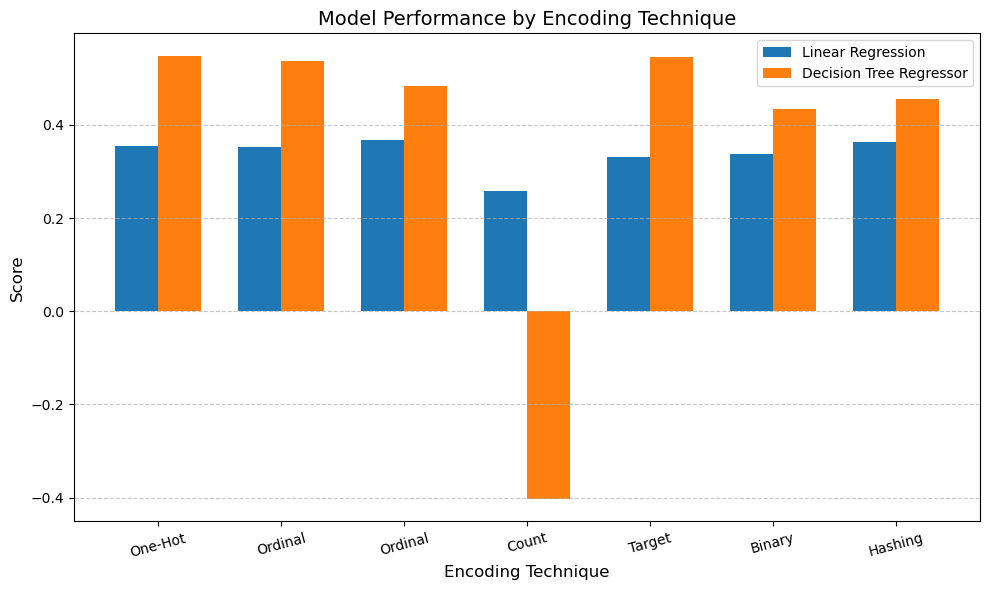

In [ ]:
columns = ['Techniques', 'Linear Regression', 'Decision Tree Regressor']
data = pd.DataFrame(scores, columns=columns)

techniques = data['Techniques']
linear_regression_scores = data['Linear Regression']
decision_tree_scores = data['Decision Tree Regressor']

x = np.arange(len(scores))

# Width of the bars
bar_width = 0.35

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plots
plt.bar(x - bar_width/2, linear_regression_scores, width=bar_width, label='Linear Regression')
plt.bar(x + bar_width/2, decision_tree_scores, width=bar_width, label='Decision Tree Regressor')

# Add labels and title
plt.xlabel('Encoding Technique', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance by Encoding Technique', fontsize=14)
plt.xticks(x, techniques, rotation=15)
plt.legend()

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()

# Tài liệu tham khảo

1. Soledad Galli, Python Feature Engineering Cookbook, Packt Publishing, 2020
2. Feature-Engine,  User Guide - Categorical Encoding, https://feature-engine.trainindata.com/en/1.7.x/user_guide/encoding/
3. Inria Learning Lab, Encoding of categorical variables, https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline.html
4. Emil Hvitfeldt, Feature Engineering A-Z, https://feaz-book.com
5. DataCamp, Handling Machine Learning Categorical Data with Python Tutorial, https://www.datacamp.com/tutorial/categorical-data